# For defining reaction templates used in polymer fragment generation

# Core Imports

In [1]:
# Custom Imports
from polymerist.rdutils import rdkdraw
from polymerist.rdutils.reactions import reactions
from polymerist.rdutils.amalgamation import portlib

from polymerist.rdutils.smileslib.functgroups import FN_GROUP_TABLE
from polymerist.monomers import specification

# File I/O
from pathlib import Path
import json

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
# RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH = Path('poly_rxns')
RXN_FILES_PATH.mkdir(exist_ok=True)

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Defining target functional groups

### Locate base SMARTS to build off of

In [2]:
gb = FN_GROUP_TABLE.groupby('group_name')
smarts_keys = {
    'hydroxyl'      : ('Hydroxyl', 156),
    'carboxyl'      : ('Carboxylic acid', 51),
    'carbamate'     : ('Carbamate.', 46),
    'acyl_chloride' : ('Acyl Halide', 237),
    'isocyanate'    : ('Cyanamide', 54),
    'ester'         : ('Ester Also hits anhydrides', 58)
}

smarts_dict, mol_dict = {}, {}
for fn_group_name, (group_key, idx) in smarts_keys.items():
    smarts = gb.get_group(group_key).loc[idx].SMARTS
    rdmol = Chem.MolFromSmarts(smarts)

    print(fn_group_name, smarts)
    # display(rdmol)

    smarts_dict[fn_group_name] = smarts 
    mol_dict[fn_group_name] = rdmol 

hydroxyl [OX2H]
carboxyl [CX3](=O)[OX2H1]
carbamate [NX3,NX4+][CX3](=[OX1])[OX2,OX1-]
acyl_chloride [CX3](=[OX1])[F,Cl,Br,I]
isocyanate [NX3][CX2]#[NX1]
ester [#6][CX3](=O)[OX2H0][#6]


### Define functional groups (with R-group linkers) as basis for desired reactions

phthalimide


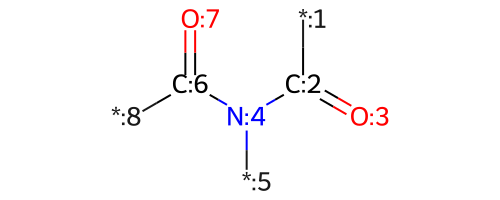

carbamate


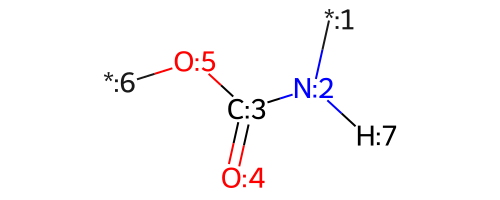

cyclocarbonate


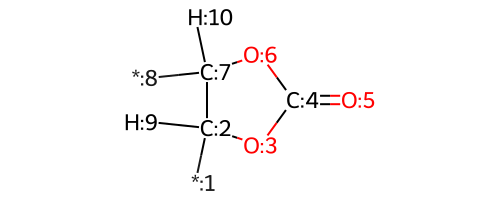

anhydride


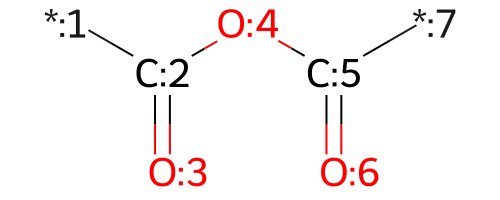

vinyl


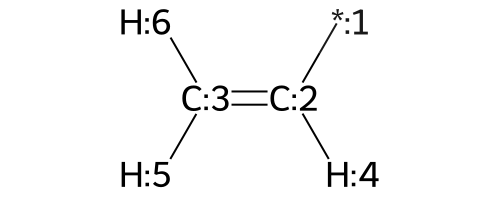

terminal_alkene


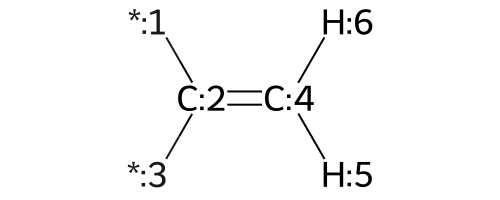

acyl_chloride


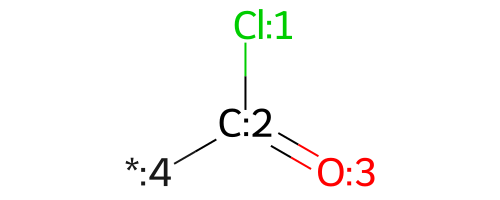

carboxyl


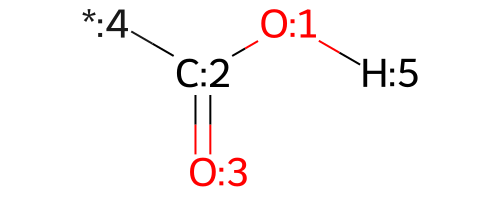

ester


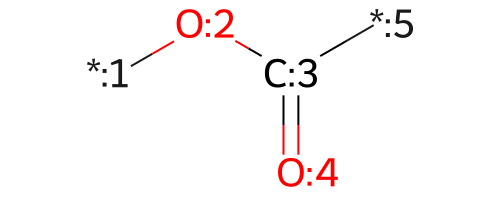

amine


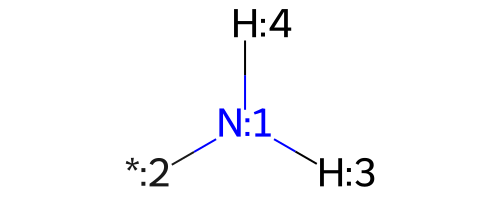

hydroxyl


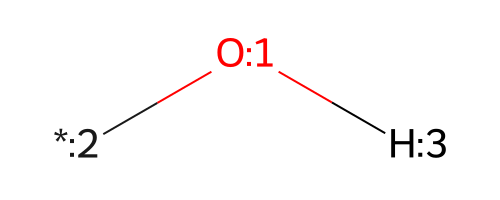

isocyanate


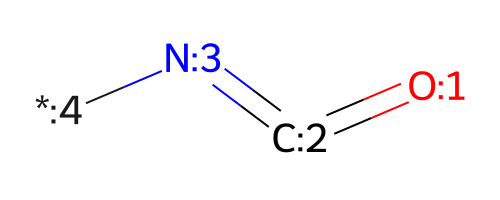

In [12]:
rdkdraw.set_rdkdraw_size(200, 5/2)

fn_group_smarts_bare = { # TODO : add specificity vis-a-vis bond degree and stereo
    'phthalimide'    : '*C(=O)N(*)C(=O)*',
    'carbamate'      : '*[NH]C(=O)O*',
    'cyclocarbonate' : '*C1OC(=O)OC1*',
    'anhydride'      : '*C(=O)OC(=O)*',
    'vinyl'          : '*C=C',
    'terminal_alkene': '*C(-*)=C',
    'acyl_chloride'  : 'Cl-C(=O)*',
    'carboxyl'       : 'OC(=O)*',
    'ester'          : '*OC(=O)*',
    'amine'          : '[NH2]*',
    'hydroxyl'       : '[OH]*',
    'isocyanate'     : 'O=C=N*',
}

fn_group_smarts, fn_groups = {}, {}
for group_name, smiles in fn_group_smarts_bare.items():
    exp_smiles = specification.expanded_SMILES(smiles, assign_map_nums=True)
    fn_group_mol = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    fn_group_mol.SetProp('_Name', group_name) # shows up as MDL mol label in file

    for atom in fn_group_mol.GetAtoms():
        if portlib.is_linker(atom):
            atom.SetProp('molFileValue', group_name)
            break # ensure this is only set once
    
    print(group_name)
    display(fn_group_mol)

    fn_group_smarts[group_name] = exp_smiles
    fn_groups[      group_name] = fn_group_mol

### Define complete small-molecule byproducts (as query mols)

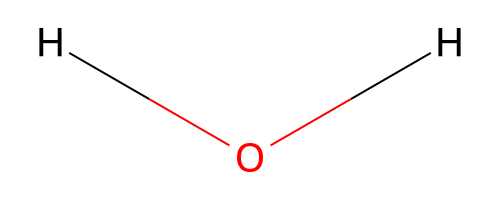

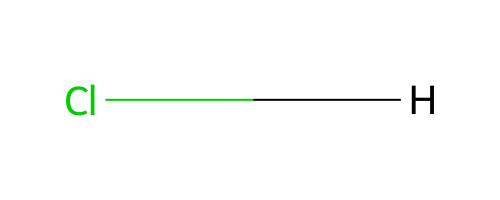

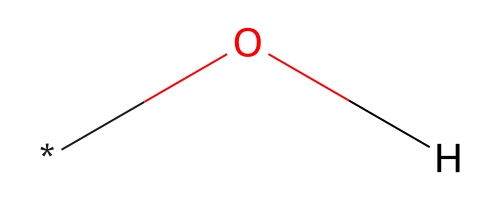

In [4]:
byproduct_smarts_bare = {
    'water' : 'O',
    'hcl'   : '[ClH]',
    'alcohol' : 'O*'
}

byproduct_smarts, byproducts = {}, {}
for group_name, smiles in byproduct_smarts_bare.items():
    exp_smiles = specification.expanded_SMILES(smiles, assign_map_nums=False)
    byproduct = Chem.MolFromSmarts(exp_smiles) # must be SMARTS for successful query

    byproduct_smarts[group_name] = exp_smiles
    byproducts[group_name] = byproduct
    display(byproduct)

## Export functional group and byproduct smiles to files

In [5]:
with (RXN_FILES_PATH / 'fn_group_smarts.json').open('w') as file:
    json.dump(fn_group_smarts, file, indent=4)

with (RXN_FILES_PATH / 'byprod_smarts.json').open('w') as file:
    json.dump(byproduct_smarts, file, indent=4)

# Defining polymerization reactions

In [15]:
from polymerist.rdutils.reactions.assembly import ReactionAssembler

rdkdraw.set_rdkdraw_size(400, 3/2)
portlib.Port.bondable_flavors.insert((1, 2)) # allows for specificity when re-bonding cleaved groups


mechanisms : dict[str, ReactionAssembler] = {
    'polyester' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['carboxyl'],
        ),
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        },
        byproducts=(
            byproducts['water'],
        )
    ),
    'polyamide' : ReactionAssembler(
        reactive_groups=(
            fn_groups['amine'],
            fn_groups['carboxyl'],
        ),
        bond_derangement= {
            1 : (3, 6),
            5 : (6, 3)
        },
        byproducts=(
            byproducts['water'],
        )
    ),
    'polyimide' : ReactionAssembler(
        reactive_groups=(
            fn_groups['amine'],
            fn_groups['anhydride'],
        ),
        bond_derangement={
            4 : (1, 8),
            6 : (8, 1),
            3 : (1, 8), # doubles up carbonyl transfer - must have target atoms as beginning to maintain canonical derangement form
            9 : (8, 1),
        },
        byproducts=(
            byproducts['water'],
        )
    ),
    'polycarbonate_phosgene' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['acyl_chloride'],
        ),
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        },
        byproducts=(
            byproducts['hcl'],
        )
    ),
    'polycarbonate_nonphosgene' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['ester'],
        ),
        bond_derangement= {
            5 : (6, 3),
            1 : (3, 6)
        },
        # bond_derangement= { # technically would give desired end products but is...
        #     4 : (5, 1), # ... inconsistent w/ mechanism of action (relative to phosgene route)...
        #     2 : (1, 5)  # ...AND prohibited by the Port spec (would produce 2 neutronium fragments which are unbondable)
        # },
        byproducts=(
            byproducts['alcohol'],
        )
    ),
    'polyurethane_isocyanate' : ReactionAssembler(
        reactive_groups=(
            fn_groups['isocyanate'],
            fn_groups['hydroxyl'],
        ),
        bond_derangement={
            7 : (5, 3),
            2 : (3, 5)
        }
    ),
    'polyurethane_nonisocyanate' : ReactionAssembler(
        reactive_groups=(
            fn_groups['cyclocarbonate'],
            fn_groups['amine'],
        ),
        bond_derangement= {
            5  : (4, 13),
            11 : (13, 4)
        }
    ),
    'polyvinyl_head_tail' : ReactionAssembler(
        reactive_groups=(
            fn_groups['terminal_alkene'],
            fn_groups['vinyl'],
        ),
        bond_derangement= {
            4  : (2, 8),
            12 : (8, 2)
        }
    ),
}

polyester {1: (3, 5), 4: (5, 3)}


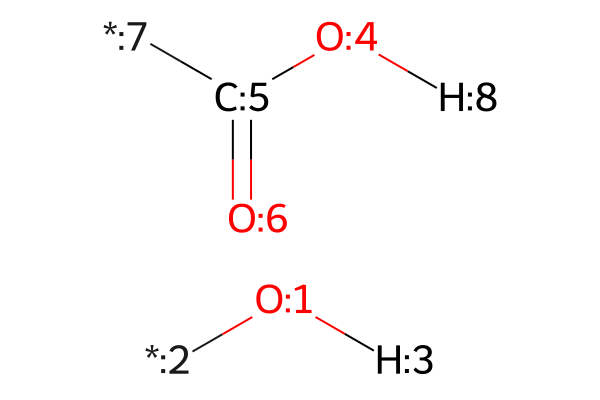

polyamide {1: (3, 6), 5: (6, 3)}


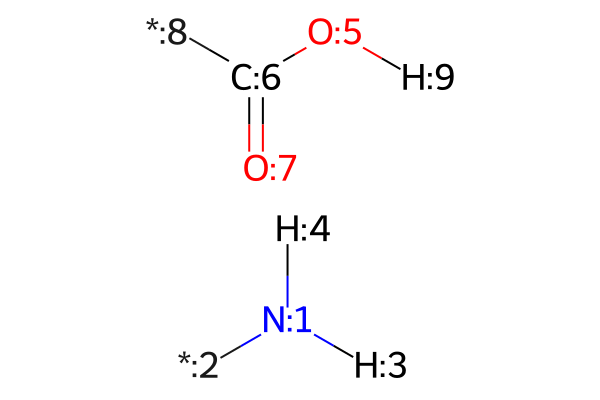

polyimide {4: (1, 8), 6: (8, 1), 3: (1, 8), 9: (8, 1)}


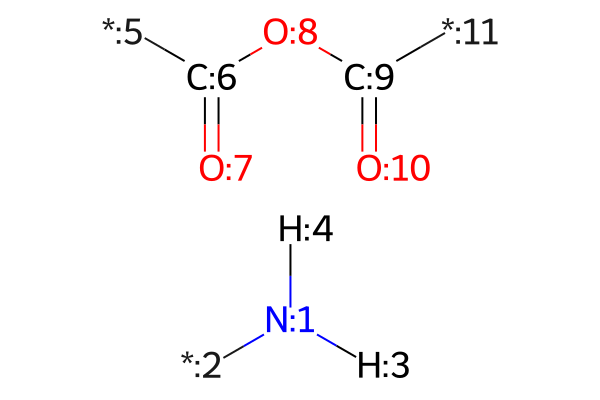

polycarbonate_phosgene {1: (3, 5), 4: (5, 3)}


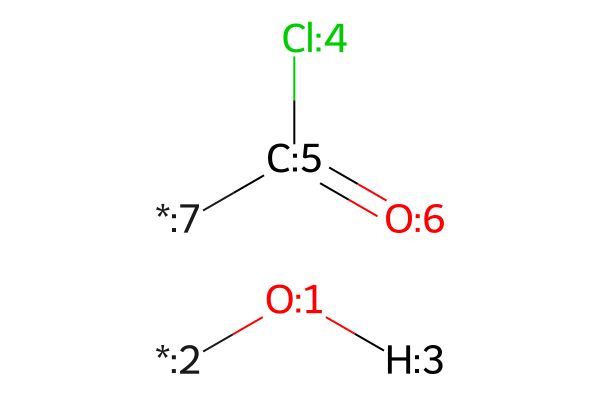

polycarbonate_nonphosgene {5: (6, 3), 1: (3, 6)}


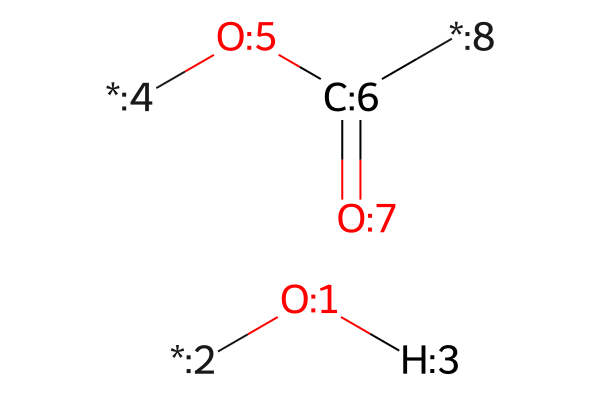

polyurethane_isocyanate {7: (5, 3), 2: (3, 5)}


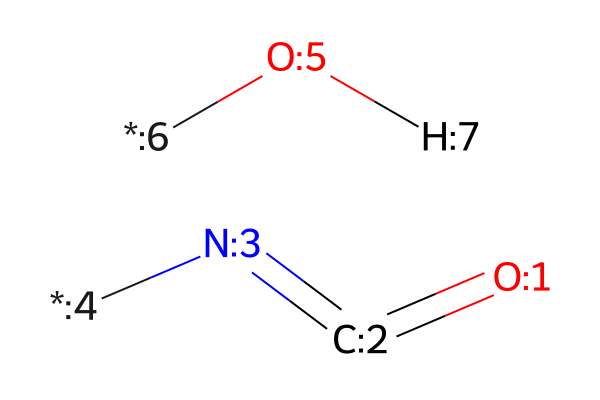

polyurethane_nonisocyanate {5: (4, 13), 11: (13, 4)}


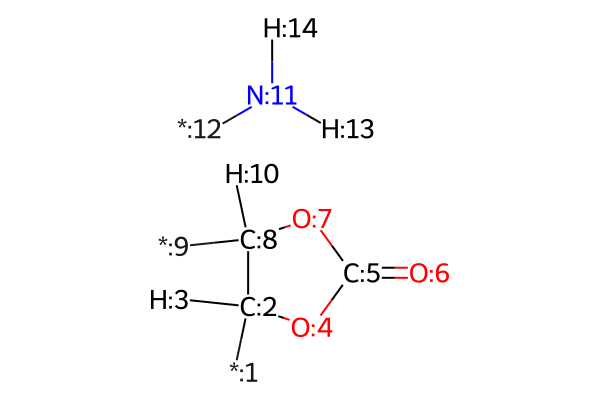

polyvinyl_head_tail {4: (2, 8), 12: (8, 2)}


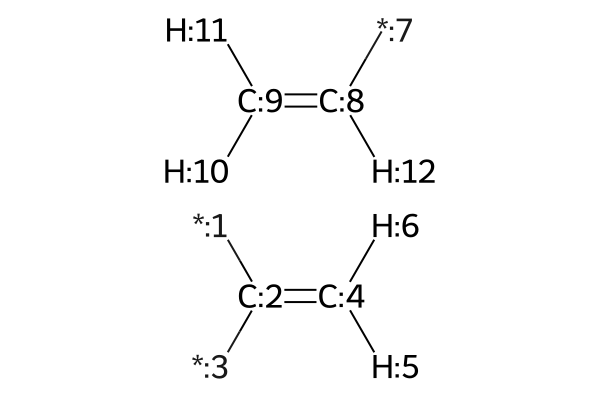

In [16]:
# display mechanism schemata prior to generating reactions (allows for inspection of derangement IDs)
for mech_name, mech_schema in mechanisms.items():
    print(mech_name, mech_schema.bond_derangement)
    display(mech_schema.reactants)

## Generating rxn MDL templates and SMARTS equations and saving to file

polyester


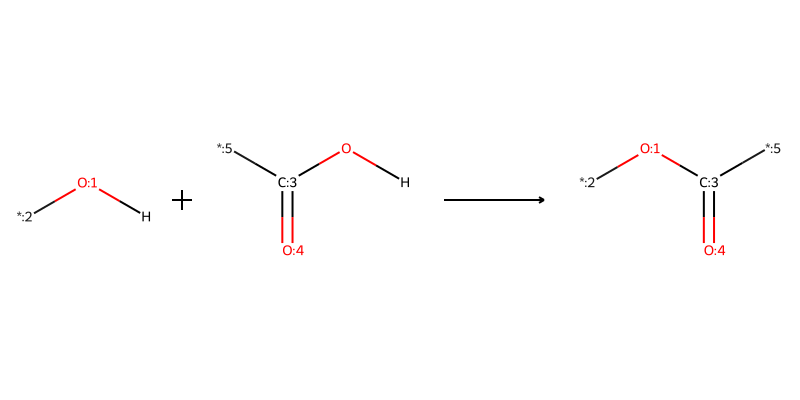

	Reactant match with hydroxyl
	Reactant match with carboxyl
polyamide


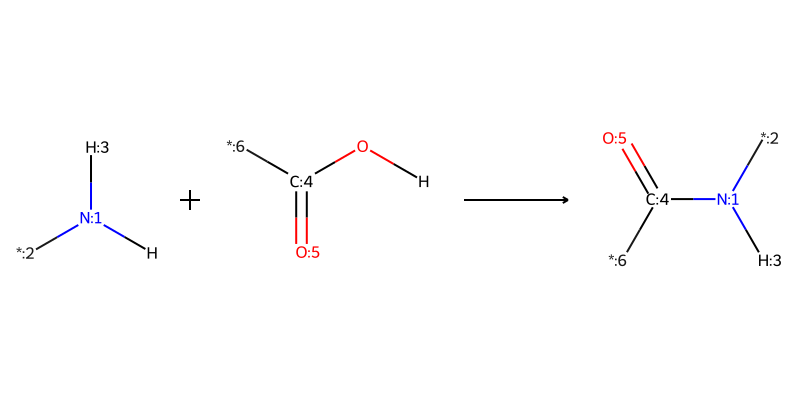

	Reactant match with amine
	Reactant match with carboxyl
polyimide


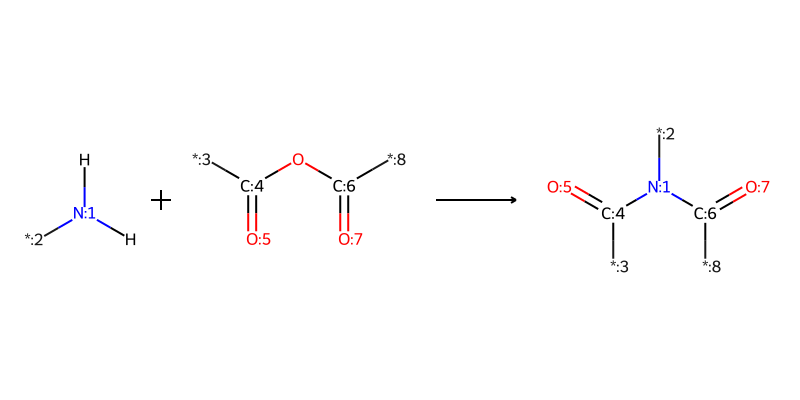

	Reactant match with amine
	Reactant match with anhydride
polycarbonate_phosgene


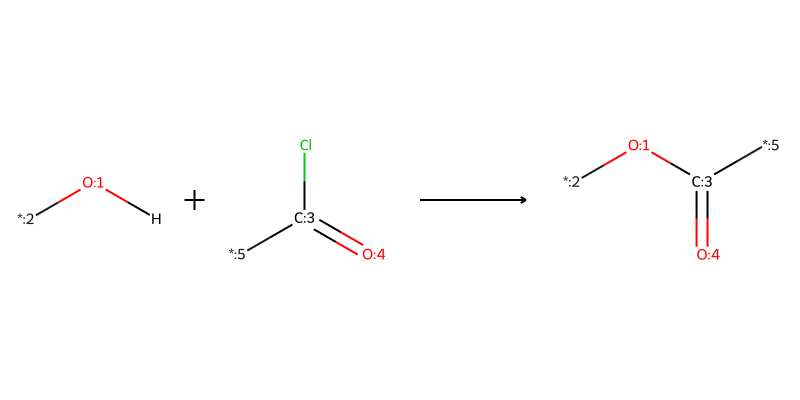

	Reactant match with hydroxyl
	Reactant match with acyl_chloride
polycarbonate_nonphosgene


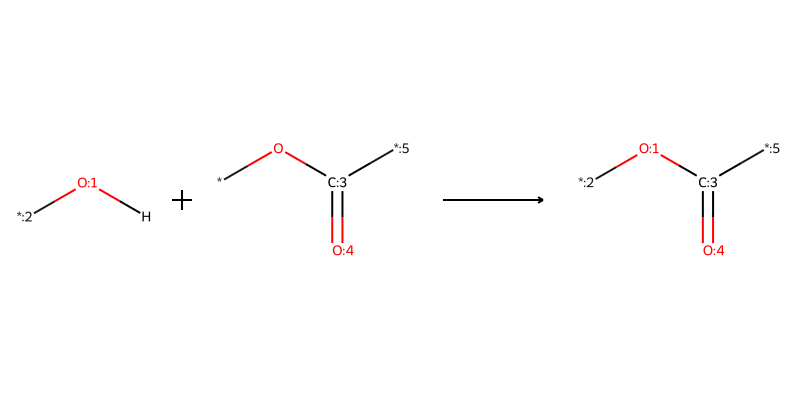

	Reactant match with hydroxyl
	Reactant match with ester
polyurethane_isocyanate


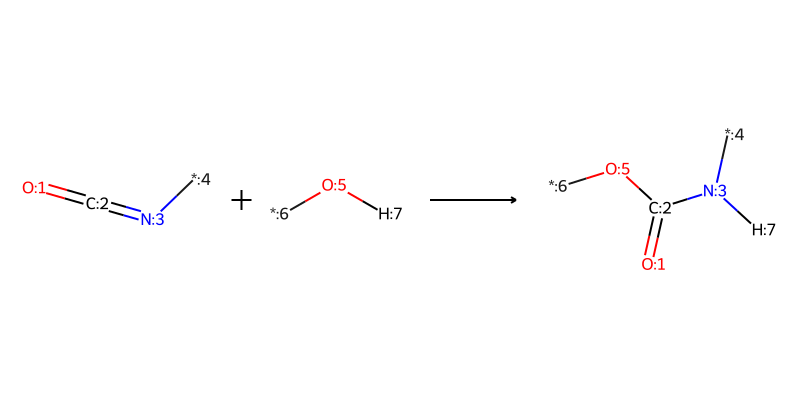

	Reactant match with isocyanate
	Reactant match with hydroxyl
polyurethane_nonisocyanate


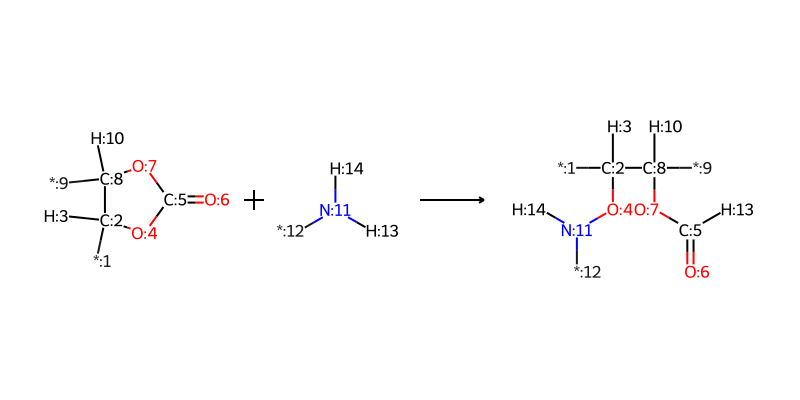

	Reactant match with cyclocarbonate
	Reactant match with amine
polyvinyl_head_tail


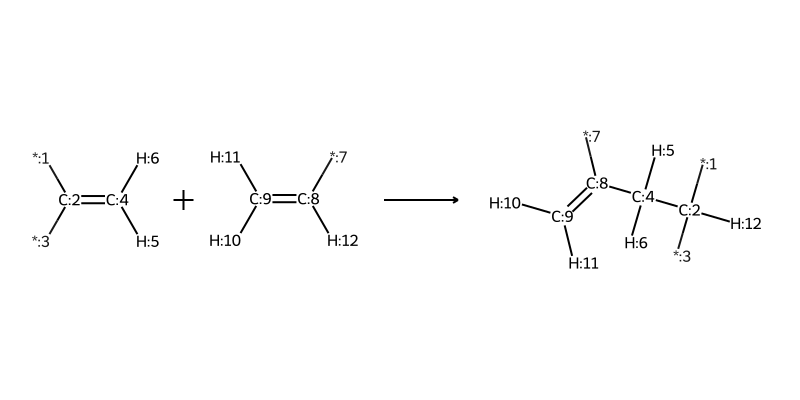

	Reactant match with terminal_alkene
	Reactant match with vinyl


In [17]:
rxns, rxn_smarts = {}, {}
for mech_name, mech_schema in mechanisms.items():
    # assemble reaction
    print(mech_name)
    rxn = mech_schema.assemble_rxn(show_steps=False)
    display(rxn)

    # add functional group names to reactants (can't be done prior due to CombineMols() calls)
    for template in rxn.GetReactants():
        for group_name, fn_group in fn_groups.items():
            if template.HasSubstructMatch(fn_group):
                template.SetProp('_Name', group_name)
                print(f'\tReactant match with {group_name}')

    rxns[mech_name] = rxn
    rxn_smarts[mech_name] = rdChemReactions.ReactionToSmarts(rxn)

In [18]:
with (RXN_FILES_PATH / 'rxn_smarts.json').open('w') as file:
    json.dump(rxn_smarts, file, indent=4)

for chemistry, rxn in rxns.items():
    rxn.to_rxnfile(RXN_FILES_PATH / f'{chemistry}.rxn', rxnname=chemistry)

# Testing that reaction actually behave as intended

In [ ]:
test_reactants = {
    'polyvinyl_head_tail' : ('C=C(CF)', 'C=C(CF)'),
    'polycarbonate_phosgene' : ('OCCO', 'ClC(=O)Cl'), 
    'polycarbonate_nonphosgene' : ('CC(C)(c1ccc(cc1)O)c2ccc(cc2)O', 'O=C(Oc1ccccc1)Oc2ccccc2'), 
}

In [ ]:
targ_rxn = 'polycarbonate_nonphosgene'

reactants = []        
for sm in test_reactants[targ_rxn]:
    exp_smiles = specification.expanded_SMILES(sm, assign_map_nums=False)
    reactant = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    display(reactant)
    reactants.append(reactant)

In [ ]:
rxn = reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_PATH / f'{targ_rxn}.rxn')
rxn.Initialize()
num_warnings, num_errors = rxn.Validate()

print(num_warnings, num_errors)
display(rxn)

In [ ]:
from polymerist.rdutils.reactions import reactors

reactor = reactors.PolymerizationReactor(rxn)
for dimer, frags in reactor.propagate(reactants):
    display(dimer)
    for frag in frags:
        display(frag)
    print('='*50)

# Playing with Stereo

In [ ]:
mech = mechanisms['polyvinyl_head_tail']
product = mech.products_by_importance()[0]
product

In [ ]:
print(Chem.StereoType.names)
print(Chem.ChiralType.names)
print(Chem.BondStereo.names)
print(Chem.BondDir.names)

In [ ]:
for atom in product.GetAtoms():
    print(atom.GetAtomMapNum(), atom.GetChiralTag())

In [ ]:
from rdkit.Chem.rdchem import StereoType, ChiralType, BondStereo, BondDir
from polymerist.rdutils.labeling import molwise

for stereo_info in Chem.FindPotentialStereo(product):
    print(f'  Type: {stereo_info.type}, Which: {stereo_info.centeredOn}, Specified: {stereo_info.specified}, Descriptor: {stereo_info.descriptor} ')
    print(stereo_info.centeredOn, next(molwise.map_nums_by_atom_ids(product, stereo_info.centeredOn)))

In [ ]:
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
from rdkit.Chem.AllChem import EmbedMolecule

options = StereoEnumerationOptions(
    onlyUnassigned=False
)

Chem.AssignStereochemistry(product, flagPossibleStereoCenters=True)
Chem.FindPotentialStereoBonds(product)

for isomer in EnumerateStereoisomers(product):
    display(isomer)
    print(Chem.MolToSmiles(isomer, isomericSmiles=True))

In [ ]:
import pubchempy as pcp


smiles = ('CC(=O)', 'c1ccccc1C=O')

mols = {}
for smi in smiles:
    pcquery = pcp.get_compounds(smi, namespace='smiles')
    pccomp = pcquery.pop()
    iupac_name = getattr(pccomp, 'iupac_name')

    mol = Chem.MolFromSmiles(smi)
    mol.SetProp('_Name', iupac_name)
    Chem.MolToMolFile(mol, f'{iupac_name}.mol')

    mols[iupac_name] = mol


mols

# Reverse-engineering example reactions from RDKit

In [ ]:
# rxn = rdChemReactions.ReactionFromRxnFile('test.rxn')
rxn = rdChemReactions.ReactionFromRxnFile('azide.rxn')
nWarn,nError,nReacts,nProds,reactantLabels = rdChemReactions.PreprocessReaction(rxn)
print(reactantLabels)
display(rxn)

In [ ]:
from polymerist.rdutils import rdprops

r1 = rxn.GetReactantTemplate(1)
print(Chem.MolToSmarts(r1))
display(r1)


rdprops.aggregate_atom_prop(r1, 'molFileValue', prop_type=str)